In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
import tensorflow as tf
import skimage.io as skio
#tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
#from image_processing2 import *
from processing import txt_preprocessing
import tf_extended as tfe
from processing import tf_image
from nets import txtbox_300
import tf_utils
from nets import custom_layers
import load_batch

In [2]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

text_shape (300, 300)
file_path: ../data/sythtext/50.tfrecord
[[119, 138, 206, 220, 234, 150, 151, 47], [270, 56, 10, 25, 18, 257, 226, 277], [153, 185, 222, 235, 248, 165, 168, 64], [353, 196, 53, 51, 49, 280, 248, 327]]


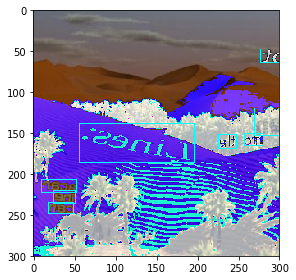

[[76, 268], [22, 122], [95, 362], [77, 168]]


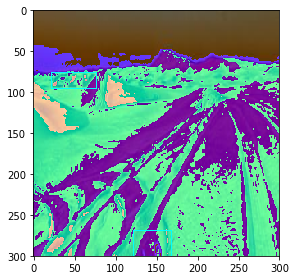

[[282, 291, 238, 129, 151, 146, 121], [131, 262, 74, 148, 30, 27, 207], [340, 333, 294, 161, 230, 214, 178], [236, 316, 148, 222, 324, 197, 297]]


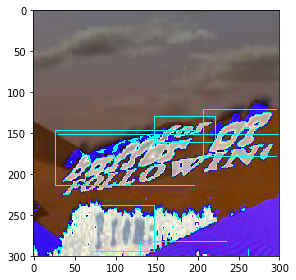

[[11, 46, 70, 94, 136, 131], [-298, -285, -73, -698, 229, -202], [48, 69, 94, 134, 168, 164], [105, 296, 323, 358, 390, 153]]


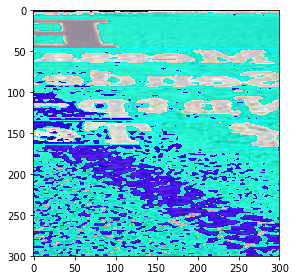

[[184, 15, 145, 250, 255, 256, 181], [283, 291, -14, 200, 224, 253, 43], [258, 55, 243, 277, 271, 273, 256], [353, 354, 101, 220, 251, 293, 144]]


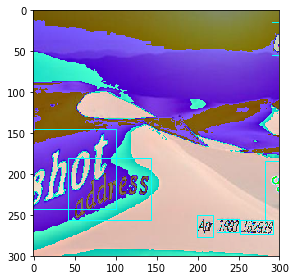

[[187, 114, 277, 281, 134], [-95, 225, 94, -92, -91], [282, 173, 301, 303, 158], [400, 759, 207, 72, 287]]


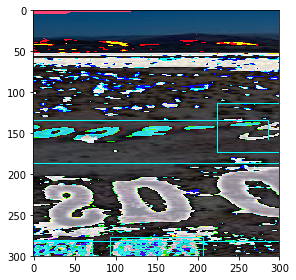

[[-15, 57], [54, 22], [24, 93], [182, 199]]


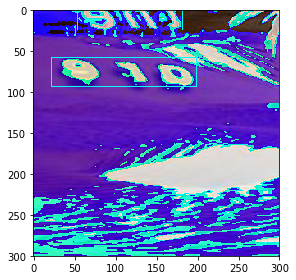

[[206, 54, 80], [141, 73, -428], [248, 83, 119], [351, 369, 329]]


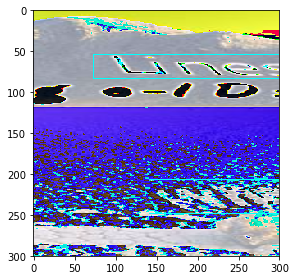

[[-4, 48, 54, 105, 142, 139, 114, -8, 292, 47, 49, 69, 124, 119, 283], [104, 27, 58, 105, 209, 274, 7, 266, 251, 47, 58, 106, 216, -11, 217], [82, 109, 137, 155, 171, 158, 155, 33, 308, 75, 104, 145, 149, 189, 296], [196, 49, 89, 122, 268, 299, 46, 340, 301, 56, 107, 175, 269, 55, 316]]


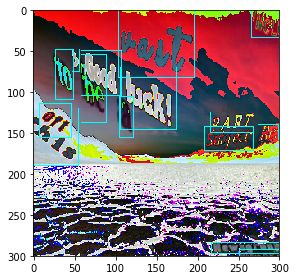

[[19, 35, 37, 19, 54], [-84, 197, 259, 27, 251], [35, 51, 48, 32, 71], [20, 239, 285, 226, 329]]


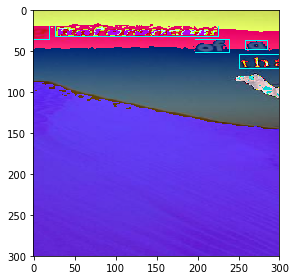

In [17]:
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='50.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])
    
    image_train, glabels, gbboxes,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=True)
    image_test, labels, bboxes, bbox_img,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],is_training=False)
    batch_image = slim.batch_norm(image_train)
    #scala_image = tf.cast(image_train, tf.uint8)
    
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(10):
                image_, batch_image_,image_test_,bbox_,test_box= sess.run([image_train,batch_image,image_test,gbboxes,bboxes])
                image_ = image_ *255.0
                image_ = image_.astype(np.uint8)
                visualize_bbox(image_, bbox_)
  
                
                

In [16]:
print image_.max(),image_.min()

0.517647 -0.458824


In [ ]:
image_test_ = image_test_ * 255.0
image_test_ = image_test_.astype(np.uint8)
visualize_bbox(image_test_, test_box)


In [ ]:
image_ = image_ *255.0
image_ = image_.astype(np.uint8)
visualize_bbox(image_, bbox_)

In [ ]:
image_ = image_.astype(np.uint8)
#skio.imshow(np.uint8(image_bbox_p[0,:,:,:])*255)
skio.imshow(image_)

In [ ]:
for i in range(6):
    pmask = gscores_[i] > 0.5
    print np.sum(pmask)
bbox_

In [ ]:
for i in range(6):
    print np.where(gscores_[i] >0.1)
gscores_[0].shape

In [ ]:
loss

In [ ]:
pos_loss = 0
neg_loss = 0
for i in range(6):
    p_mask = np.int32(np.greater(b_gscores_[i] , 0.5))
    print np.sum(p_mask)
    n_mask = np.int32(np.less(b_gscores_[i] , 0.5))
    pos_loss += np.mean(pow((p_mask * (logits_[i][:,:,:,:,:,1] - p_mask)),2))
    neg_loss += np.mean(pow((n_mask * (logits_[i][:,:,:,:,:,0] - n_mask)),2))
print pos_loss,neg_loss